<div style="text-align: right"><i>Ivy Zhang<br>2024</i></div>

## Vose Alias Method

I first saw this mentioned in the [Node2Vec paper](https://arxiv.org/abs/1607.00653) where they used this technique to sample from a discrete distribution in $O(1)$!

For an extremely well written essay on this method: you should go read [Darts, Dice, & Coin](https://www.keithschwarz.com/darts-dice-coins/). I've tried to provide the cleanest solution I can think of in Python here :)

In [158]:
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from typing import Tuple, List

In [159]:
def precompute_tables(sample: List[float]) -> Tuple[List[float], List[int]]:
    """
    Precomputes tables to be able to sample from in O(1) later.
    
    Takes in an arbitrary list of floats and converts them to probability. It
    then returns a Probs array and Alias array.
    """
    n = len(sample)

    res_alias = [None for _ in range(n)]
    res_probs = [0 for _ in range(n)]

    # These are stacks like mentioned in array
    small_idxs = []
    large_idxs = []

    # First convert inputs into probabilities
    sample_sum = sum(sample)
    probs = [x / sample_sum for x in sample]

    # We then scale it so that average prob (1/n) would become 1
    probs = [x * n for x in probs]

    # Create your stacks
    for i, p in enumerate(probs):
        if p < 1:
            small_idxs.append(i)
        else:
            large_idxs.append(i)

    # Continue pairing large and small pairings to fill columns
    while len(small_idxs) and len(large_idxs):
        si = small_idxs.pop()
        li = large_idxs.pop()

        res_probs[si] = probs[si]
        res_alias[si] = li
        probs[li] = (probs[li] + probs[si] - 1.0)

        if probs[li] < 1.0:
            small_idxs.append(li)
        else:
            large_idxs.append(li)

    # These are just to deal with numerical instability
    # Anything left here should just be it's own column
    while len(small_idxs):
        si = small_idxs.pop()
        res_probs[si] = 1.0

    while len(large_idxs):
        si = large_idxs.pop()
        res_probs[si] = 1.0

    return (res_probs, res_alias)

In [160]:
def generate(probs, alias):
    """
    Generates a random element with a fair dice and a biased coin toss.
    """
    n = len(probs)
    idx = math.floor(random.random() * n)
    flip = random.random()
    return idx if flip < probs[idx] else alias[idx]
    

In [161]:
num_gens = 10_000_000
inputs = [20, 2, 10, 16, 30, 5]
p_table, alias_table = precompute_tables(inputs)

res = [0 for _ in range(len(inputs))]

for _ in range(num_gens):
    res[generate(p_table, alias_table)] += 1

res_scaled = [x/sum(res) for x in res]
inputs_scaled = [x/sum(inputs) for x in inputs]

In [162]:
print('Initial distribution:', inputs_scaled)
print(f'Dist after {num_gens} samples:', res_scaled)

Initial distribution: [0.24096385542168675, 0.024096385542168676, 0.12048192771084337, 0.1927710843373494, 0.3614457831325301, 0.060240963855421686]
Dist after 10000000 samples: [0.2412024, 0.0240788, 0.1202891, 0.1928849, 0.3611357, 0.0604091]


Just in case that wasn't definitive, here's some code to plot the sampled distribution against the original one. (Heavily borrowed from the [matplotlib tutorials](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)).

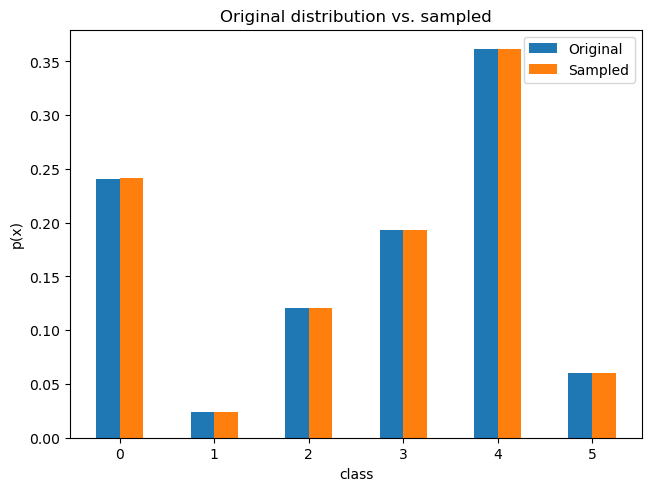

In [163]:
x = np.arange(len(inputs))
width = 0.25  # the width of the bars

fig, ax = plt.subplots(layout='constrained')

ax.bar(x, inputs_scaled, width, label = 'Original')
ax.bar(x + width, res_scaled, width, label = 'Sampled')

ax.set_ylabel('p(x)')
ax.set_xlabel('class')
ax.set_title('Original distribution vs. sampled')
ax.set_xticks(x+width / 2, x)
ax.legend()

plt.show()